In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, balanced_accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import os
import pickle

In [2]:
df = pd.read_csv('../../2-cleaning-EDA/data/pros.csv')

In [3]:
df.shape

(958, 48)

In [4]:
df.drop(columns = ['Unnamed: 0',
                   'mvp',
                   'taken',
                   'goals',
                   'assists',
                   'avg_distance_to_ball_possession',
                   'shots',
                   'amount_stolen'
                  ],
                   inplace = True)

In [5]:
df.iloc[0, :]

saves                                         0
score                                       378
bcpm                                  420.76846
avg_amount                                48.78
amount_collected                           2338
amount_collected_big                       1535
amount_collected_small                      803
amount_overfill                             296
amount_used_while_supersonic                389
percent_zero_boost                    12.957797
percent_full_boost                    10.159272
percent_boost_0_25                    33.467205
percent_boost_25_50                   27.739504
percent_boost_50_75                   10.636721
percent_boost_75_100                  28.156569
count_powerslide                             84
avg_powerslide_duration                    0.12
avg_speed_percentage                   66.13043
percent_slow_speed                     47.60705
percent_boost_speed                   38.449085
percent_supersonic_speed              13

In [6]:
X = df.drop(columns = 'player_name')
y = df.player_name

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [7]:
y_train.value_counts(normalize = True)

Vati           0.398329
Oski           0.337047
M0nkey M00n    0.264624
Name: player_name, dtype: float64

In [8]:
ss = StandardScaler()

# X_train = pd.DataFrame(ss.fit_transform(X_train), columns = ss.get_feature_names_out())
# X_test = pd.DataFrame(ss.transform(X_test), columns = ss.get_feature_names_out())


In [9]:
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [10]:
knn.score(X_train, y_train)

0.8690807799442897

In [11]:
knn.score(X_test, y_test)

0.6958333333333333

In [12]:
et = ExtraTreesClassifier()

et.fit(X_train, y_train)


ExtraTreesClassifier()

In [13]:
et.score(X_train, y_train)

1.0

In [14]:
et.score(X_test, y_test)

0.9125

In [15]:
poly = PolynomialFeatures(interaction_only=True)

X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns=poly.get_feature_names_out())
X_test_poly = pd.DataFrame(poly.transform(X_test), columns=poly.get_feature_names_out())

In [16]:
X_train_poly.shape

(718, 781)

In [17]:
knn.fit(X_train_poly, y_train)

KNeighborsClassifier(n_neighbors=2)

In [18]:
knn.score(X_train_poly, y_train)

0.8635097493036211

In [19]:
knn.score(X_test_poly, y_test)

0.7083333333333334

In [20]:
et.fit(X_train_poly, y_train)

ExtraTreesClassifier()

In [21]:
et.score(X_train_poly, y_train)

1.0

In [22]:
et.score(X_test_poly, y_test)

0.9083333333333333

In [23]:
def get_accuracies(X_train, y_train, X_test, y_test, model, model_name:str, scores_df=None, norm=None, confusion = True):
    
    # Takes training and test splits, a desired model and model name (string),
    # current scoring dataframe and norm parameter for the heatmap output
    
    # Creates columns for scoring metrics on first run
    if scores_df is None:
        scores_df = pd.DataFrame(columns = ['train_acc', 'test_acc', 'bal_acc'])
    
    # fits model to training data
    model.fit(X_train, y_train)
    
    # produces a confusion matrix for the prediction and true values of the test data
    if confusion == True:
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', normalize=norm)
    
    # predicted subreddits for each row, used to calculate balanced accuracy
    preds = model.predict(X_test)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    bal_acc = balanced_accuracy_score(y_test, preds)

    # dataframe updated with model name and corresponding scores
    scores_df.loc[model_name,:] = [train_acc, test_acc, bal_acc]
    
    print(scores_df)
    
    return scores_df

In [24]:
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [25]:
gs_knn = GridSearchCV(
    pipe_knn,
    param_grid={
        'knn__n_neighbors' : [3, 5, 7, 9, 10, 15],
        'knn__weights' : ['uniform', 'distance'],
        'knn__p' : [1, 1.5, 2]
    },
    cv = 3,
    verbose = 1,
    n_jobs = -1,
    scoring='balanced_accuracy'
)

In [26]:
gs_knn.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 10, 15],
                         'knn__p': [1, 1.5, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='balanced_accuracy', verbose=1)

In [27]:
gs_knn.best_params_

{'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}

    train_acc test_acc   bal_acc
knn       1.0   0.8625  0.868717


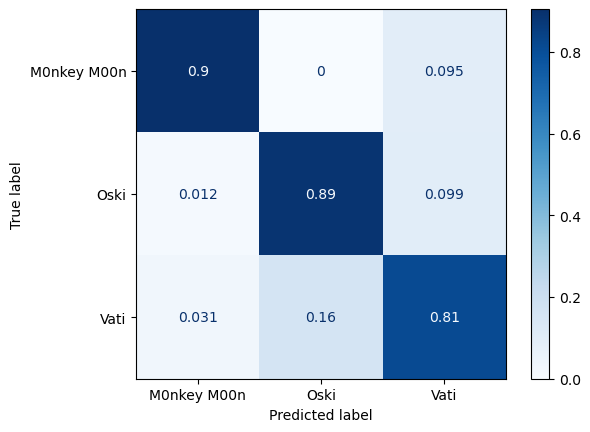

In [28]:
scores_df = get_accuracies(X_train, y_train, X_test, y_test, 
                           gs_knn.best_estimator_, 
                           'knn',
                           norm = 'true')

In [29]:
pipe_et = Pipeline([
#     ('ss', StandardScaler()),
    ('et', ExtraTreesClassifier())
])

In [30]:
gs_et = GridSearchCV(
    pipe_et,
    param_grid={
        'et__n_estimators' : [46],
        'et__max_depth' : [5,7,10,15],
        'et__min_samples_split' : [1.0, 2,3,4]
    },
    cv = 5,
    verbose = 1,
    n_jobs = -1,
    scoring = 'balanced_accuracy'
)

In [31]:
gs_et.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [5, 7, 10, 15],
                         'et__min_samples_split': [1.0, 2, 3, 4],
                         'et__n_estimators': [46]},
             scoring='balanced_accuracy', verbose=1)

In [32]:
gs_et.best_estimator_

Pipeline(steps=[('et',
                 ExtraTreesClassifier(max_depth=15, min_samples_split=3,
                                      n_estimators=46))])

    train_acc test_acc   bal_acc
knn       1.0   0.8625  0.868717
et        1.0   0.9125  0.911027


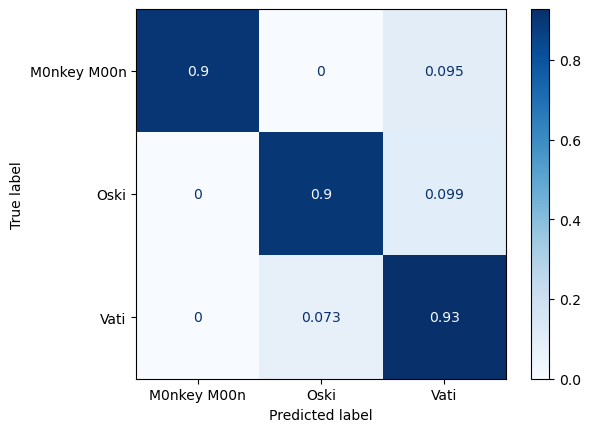

In [33]:
scores_df = get_accuracies(X_train, y_train, X_test, y_test, 
                           gs_et.best_estimator_, 
                           'et',
                           scores_df = scores_df,
                           norm = 'true')

In [34]:
importances = gs_et.best_estimator_.named_steps['et'].feature_importances_

In [35]:
features = []
for i in range(39):
    features.append((importances[i],df.columns[i]))

In [36]:
features.sort()

In [37]:
features = features[::-1]

In [38]:
feature_importances = pd.DataFrame(features, columns = ['prediction weight', 'stat'])

In [39]:
feature_importances

,prediction weight,stat
0,0.057702,count_powerslide
1,0.056005,bcpm
2,0.055926,percent_supersonic_speed
3,0.045361,percent_full_boost
4,0.042042,percent_low_air
5,0.040600,percent_farthest_from_ball
6,0.040424,percent_ground
7,0.039149,percent_slow_speed
8,0.038844,avg_speed_percentage
9,0.035933,percent_boost_75_100


In [40]:
gs_et.fit(X_train_poly, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [5, 7, 10, 15],
                         'et__min_samples_split': [1.0, 2, 3, 4],
                         'et__n_estimators': [46]},
             scoring='balanced_accuracy', verbose=1)

        train_acc test_acc   bal_acc
knn           1.0   0.8625  0.868717
et            1.0   0.9125  0.911027
et_poly       1.0   0.9125  0.913599


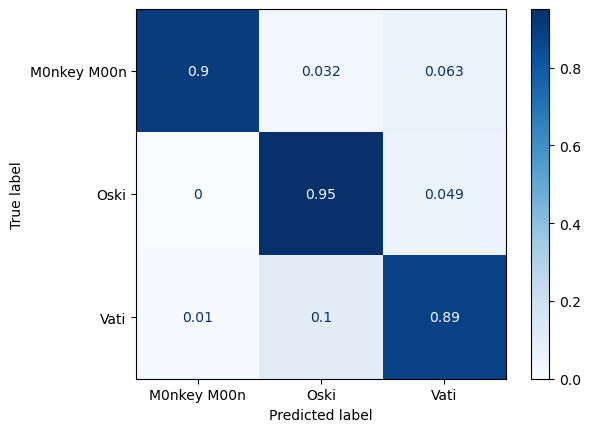

In [41]:
scores_df = get_accuracies(X_train_poly, y_train, X_test_poly, y_test, 
                           gs_et.best_estimator_, 
                           'et_poly',
                           scores_df = scores_df,
                           norm = 'true')

In [42]:
probabilities = pd.DataFrame(gs_et.best_estimator_.predict_proba(X_test_poly), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

In [43]:
probabilities

,MonkeyMoon,Oski,Vatira
0,0.000000,1.000000,0.000000
1,0.065217,0.054348,0.880435
2,0.967391,0.021739,0.010870
3,0.858696,0.108696,0.032609
4,0.706522,0.054348,0.239130
...,...,...,...
235,0.869565,0.000000,0.130435
236,0.815217,0.097826,0.086957
237,0.000334,0.261854,0.737812
238,0.000000,1.000000,0.000000


In [44]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [45]:
mnb.score(X_train, y_train)

0.6044568245125348

In [46]:
mnb.score(X_test, y_test)

0.6333333333333333

In [47]:
pipe_gnb = Pipeline([
    ('ss', StandardScaler()),
    ('gnb', GaussianNB())
])

In [48]:
gs_gnb = GridSearchCV(
    pipe_gnb,
    param_grid = {
    },
    cv = 5,
    verbose = 1,
    n_jobs = -1,
    scoring = 'balanced_accuracy'
)

In [49]:
gs_gnb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('gnb', GaussianNB())]),
             n_jobs=-1, param_grid={}, scoring='balanced_accuracy', verbose=1)

        train_acc test_acc   bal_acc
knn           1.0   0.8625  0.868717
et            1.0   0.9125  0.911027
et_poly       1.0   0.9125  0.913599
gnb      0.779944    0.725  0.740649


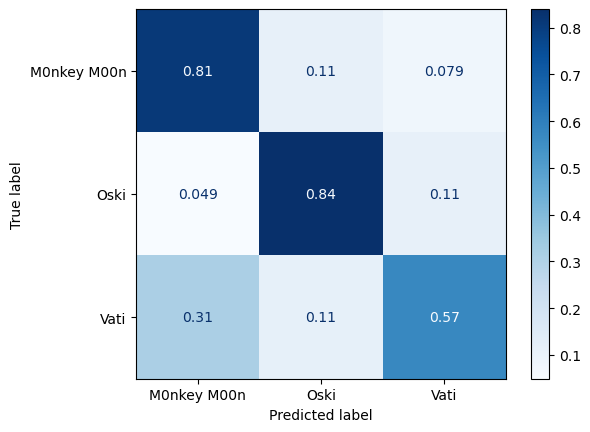

In [50]:
scores_df = get_accuracies(X_train, y_train, X_test, y_test, 
                           gs_gnb.best_estimator_, 
                           'gnb',
                           scores_df = scores_df,
                           norm = 'true')

In [51]:
stack = [
#     ('gnb', gs_gnb.best_estimator_),
    ('knn', gs_knn.best_estimator_)
]

stx = StackingClassifier(
    estimators=stack,
    final_estimator=gs_et.best_estimator_
)

        train_acc  test_acc   bal_acc
knn           1.0    0.8625  0.868717
et            1.0    0.9125  0.911027
et_poly       1.0    0.9125  0.913599
gnb      0.779944     0.725  0.740649
stack         1.0  0.841667  0.845789


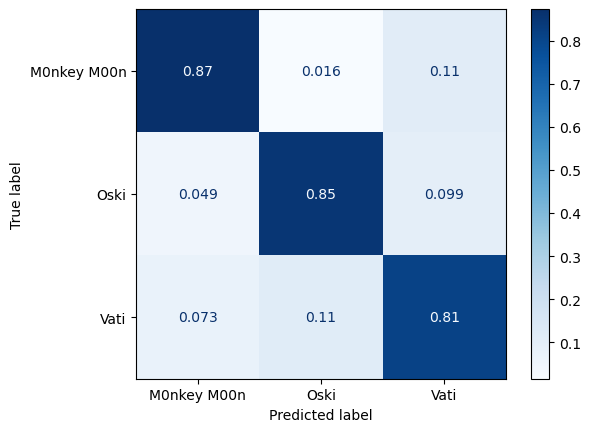

In [52]:
scores_df = get_accuracies(X_train, y_train, X_test, y_test, 
                           stx, 
                           'stack',
                           scores_df = scores_df,
                           norm = 'true')

In [53]:
gs_knn.fit(X_train_poly, y_train)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 10, 15],
                         'knn__p': [1, 1.5, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='balanced_accuracy', verbose=1)

In [54]:
gs_et.fit(X_train_poly, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('et', ExtraTreesClassifier())]),
             n_jobs=-1,
             param_grid={'et__max_depth': [5, 7, 10, 15],
                         'et__min_samples_split': [1.0, 2, 3, 4],
                         'et__n_estimators': [46]},
             scoring='balanced_accuracy', verbose=1)

In [55]:
stack = [
#     ('gnb', gs_gnb.best_estimator_),
    ('knn', gs_knn.best_estimator_)
]

stx = StackingClassifier(
    estimators=stack,
    final_estimator=gs_et.best_estimator_
)

In [56]:
stx.fit(X_train, y_train)

StackingClassifier(estimators=[('knn',
                                Pipeline(steps=[('ss', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=7,
                                                                      p=1,
                                                                      weights='distance'))]))],
                   final_estimator=Pipeline(steps=[('et',
                                                    ExtraTreesClassifier(max_depth=10,
                                                                         n_estimators=46))]))

In [57]:
stx.fit(X_train_poly, y_train)

StackingClassifier(estimators=[('knn',
                                Pipeline(steps=[('ss', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier(n_neighbors=7,
                                                                      p=1,
                                                                      weights='distance'))]))],
                   final_estimator=Pipeline(steps=[('et',
                                                    ExtraTreesClassifier(max_depth=10,
                                                                         n_estimators=46))]))

           train_acc  test_acc   bal_acc
knn              1.0    0.8625  0.868717
et               1.0    0.9125  0.911027
et_poly          1.0    0.9125  0.913599
gnb         0.779944     0.725  0.740649
stack            1.0  0.841667  0.845789
stack_poly       1.0  0.879167  0.882073


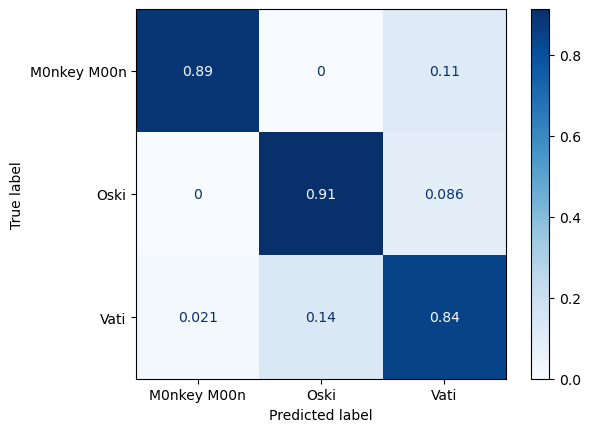

In [58]:
scores_df = get_accuracies(X_train_poly, y_train, X_test_poly, y_test, 
                           stx, 
                           'stack_poly',
                           scores_df = scores_df,
                           norm = 'true'
                           )

In [60]:
nn_y = y.replace({
    'M0nkey M00n' : 0,
    'Oski' : 1,
    'Vati' : 2
})

In [61]:
nn_y.value_counts()

2    382
1    323
0    253
Name: player_name, dtype: int64

In [62]:
nn_y = to_categorical(nn_y)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, nn_y, random_state=42, stratify=y)
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [81]:
model = Sequential()

model.add(Dense(32,
                input_shape = (39,),
                activation = 'relu'
               )
         )

model.add(Dense(16,
                activation='relu'
               )
         )

model.add(Dense(8,
                activation='relu'
               )
         )

model.add(Dense(3,
                activation = 'softmax'
               )
         )

In [82]:
model.compile(loss = 'categorical_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [83]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience = 10,
                           min_delta = 0.00,
                           restore_best_weights=True
                          )

In [84]:
history = model.fit(X_train, y_train, 
          validation_data=(X_test, y_test), 
          epochs = 150, 
          batch_size = 512,
          callbacks = [early_stop]
                   )

Epoch 1/150
2/2 [==============================] - 5s 1s/step - loss: 1.1237 - acc: 0.3482 - val_loss: 1.0996 - val_acc: 0.3667
Epoch 2/150
2/2 [==============================] - 0s 337ms/step - loss: 1.1006 - acc: 0.3677 - val_loss: 1.0783 - val_acc: 0.3750
Epoch 3/150
2/2 [==============================] - 0s 201ms/step - loss: 1.0794 - acc: 0.3774 - val_loss: 1.0580 - val_acc: 0.4000
Epoch 4/150
2/2 [==============================] - 0s 204ms/step - loss: 1.0604 - acc: 0.3928 - val_loss: 1.0385 - val_acc: 0.4333
Epoch 5/150
2/2 [==============================] - 0s 266ms/step - loss: 1.0415 - acc: 0.4248 - val_loss: 1.0200 - val_acc: 0.4667
Epoch 6/150
2/2 [==============================] - 0s 336ms/step - loss: 1.0248 - acc: 0.4373 - val_loss: 1.0024 - val_acc: 0.4750
Epoch 7/150
2/2 [==============================] - 0s 198ms/step - loss: 1.0088 - acc: 0.4624 - val_loss: 0.9866 - val_acc: 0.5000
Epoch 8/150
2/2 [==============================] - 0s 138ms/step - loss: 0.9934 - acc:

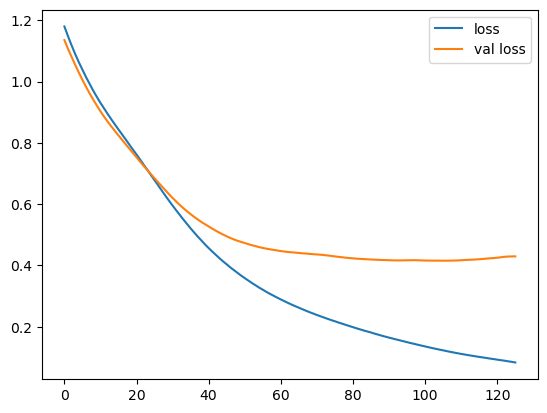

In [68]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend();

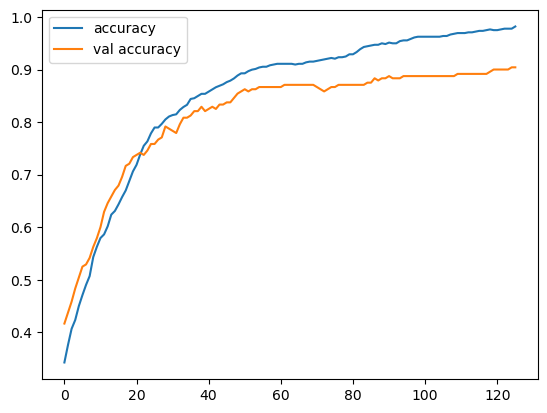

In [69]:
plt.plot(history.history['acc'], label = 'accuracy')
plt.plot(history.history['val_acc'], label = 'val accuracy')
plt.legend();

In [70]:
model.evaluate(X_test, y_test)[1]

8/8 [==============================] - 0s 36ms/step - loss: 0.4154 - acc: 0.8875


0.887499988079071

In [71]:
nn_predictions = pd.DataFrame(model.predict(X_test), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

8/8 [==============================] - 0s 5ms/step


In [72]:
nn_predictions

,MonkeyMoon,Oski,Vatira
0,0.000184,0.998563,0.001253
1,0.037584,0.030237,0.932179
2,0.964291,0.032393,0.003316
3,0.893555,0.103000,0.003445
4,0.985905,0.008375,0.005720
...,...,...,...
235,0.995069,0.003574,0.001357
236,0.921926,0.062076,0.015998
237,0.001012,0.027748,0.971240
238,0.010444,0.685722,0.303834


In [73]:
probabilities

,MonkeyMoon,Oski,Vatira
0,0.000000,1.000000,0.000000
1,0.065217,0.054348,0.880435
2,0.967391,0.021739,0.010870
3,0.858696,0.108696,0.032609
4,0.706522,0.054348,0.239130
...,...,...,...
235,0.869565,0.000000,0.130435
236,0.815217,0.097826,0.086957
237,0.000334,0.261854,0.737812
238,0.000000,1.000000,0.000000


In [75]:
with open('nn_model_2.pkl', 'wb') as picklefile:
    pickle.dump(model, picklefile)

In [76]:
model.save('tf_save_model_2')

INFO:tensorflow:Assets written to: tf_save_model_2/assets


INFO:tensorflow:Assets written to: tf_save_model_2/assets


In [77]:
with open('et_model_2.pkl', 'wb') as picklefile:
    pickle.dump(gs_et.best_estimator_, picklefile)

In [78]:
boay = pd.read_csv('../data/boay_.csv')

In [86]:
boay_preds = pd.DataFrame(model.predict(boay.drop(columns = ['Unnamed: 0','player_name']),
                                             ), columns = ['MonkeyMoon', 'Oski', 'Vatira'])

1/1 [==============================] - 0s 164ms/step


In [87]:
boay_predictions

,MonkeyMoon,Oski,Vatira
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
5,0.0,1.0,0.0
6,0.0,1.0,0.0
7,0.0,1.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0
